In [1]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
from itertools import chain
import patsy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
all_h2_rg = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/all_h2_rg.tsv",index_col="factor")

In [3]:
cfafactors = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/TRAINING/redux10point2/for_jupyter/loadings.txt",sep="\t")

In [4]:
factordict = cfafactors.groupby('factor')["item "].apply(lambda x: x.tolist()).to_dict()

In [5]:
nealeh2 = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/ukb31063_h2_all.02Oct2019.tsv.gz", sep="\t")

/local/scratch/41945683.1.interactive/ipykernel_41818/135564914.py:1: DtypeWarning: Columns (2,792) have mixed types. Specify dtype option on import or set low_memory=False.
  nealeh2 = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/ukb31063_h2_all.02Oct2019.tsv.gz", sep="\t")


In [6]:
nealeh2_bothsexes = nealeh2[nealeh2.sex=="both_sexes"]
nealeh2_bothsexes_dropirnt = nealeh2_bothsexes[~(nealeh2_bothsexes.variable_type=="continuous_irnt")]
nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.phenotype.apply(lambda x: "_raw" in x),"phenotype"] = nealeh2_bothsexes_dropirnt[nealeh2_bothsexes_dropirnt.phenotype.apply(lambda x: "_raw" in x)].phenotype.apply(lambda x: x.split("_")[0])
nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.source=="icd10","phenotype"] = nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.source=="icd10"].phenotype.apply(lambda x: "41202_"+x)

In [7]:
cfaitems = cfafactors["item "].values
cfaitems = [x[1:] for x in cfaitems]

In [8]:
nealeh2_items = nealeh2_bothsexes_dropirnt[nealeh2_bothsexes_dropirnt.phenotype.isin(cfaitems)]

In [9]:
nealeh2_items_only = nealeh2_items[["phenotype","h2_observed","h2_observed_se","Neff"]].set_index("phenotype")

In [10]:
all_h2_rg["h2_lower"] = all_h2_rg["h2_full"]-all_h2_rg["h2_se_full"]
all_h2_rg["h2_upper"] = all_h2_rg["h2_full"]+all_h2_rg["h2_se_full"]
all_h2_rg["h2"] = all_h2_rg["h2_full"]

In [11]:
cfafactors["abs_loading"] = abs(cfafactors["loading"])
cfafactors = cfafactors.sort_values(["factor","abs_loading"],ascending=[True,False])
cfafactors["orderednum"] = cfafactors.groupby('factor').cumcount().add(1)
cfafactors["item"] = cfafactors.apply(lambda x: x["item "][1:],axis=1)
cfafactors = cfafactors.drop("item ",axis=1)
cfafactors = cfafactors[cfafactors.orderednum<=10]

In [12]:
phenoNames = pd.read_csv("/psych/genetics_data/ccarey/UKBB/factor_gwas/core_data_group/FA_core_FieldNames.csv",index_col="Unnamed: 0")

phenolabels = pd.Series(phenoNames["name"],index=phenoNames.index).to_dict()

In [13]:
var_annot = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/test_wls_gwas/variants.tsv',sep="\t")

/local/scratch/41945683.1.interactive/ipykernel_41818/3205749484.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  var_annot = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/test_wls_gwas/variants.tsv',sep="\t")


In [14]:
cfafactors_top5 = cfafactors[cfafactors.orderednum<=5]

In [15]:
for factor in ["f16"]:
    #print(file)
    factor_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/for_fuma/'+factor+'.tsv',sep="\t")
    gwas_plusannot = factor_gwas.dropna(subset=["p_value"])
    data = gwas_plusannot[["chr","pos","p_value"]]
    data.loc[data.p_value==0,"p_value"] = 10**(-320)
    data['-log10(p_value)'] = -np.log10(data["p_value"])
    data["chr"] = data["chr"].replace("X",23)
    data["chr"] = data["chr"].astype('int')
    data["key"] = data.apply(lambda x: str(int(x.chr))+":"+str(int(x.pos)),axis=1)
    data = data.set_index("key")
    
    cfafac = cfafactors_top5.loc[cfafactors_top5["factor"]==factor]
    
    or_gwas = pd.DataFrame(columns=["p_value"])
    for i,item in enumerate(cfafac["item"].values):
        print(item)
        try:
            item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item+".tsv",sep="\t")
        except:
            try:
                item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item+"_raw.tsv",sep="\t")
            except:
                item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item.split("_")[1]+".tsv",sep="\t")
        or_gwas = or_gwas.join(item_gwas["p_value"],how="right",rsuffix="_"+str(i))
        
    or_gwas["p_value"] = or_gwas.min(axis=1)
    or_gwas_plusannot = pd.concat([or_gwas,item_gwas[["chr","pos"]]],axis=1)
    dataitem = or_gwas_plusannot[["chr","pos","p_value"]]
    dataitem.loc[dataitem.p_value==0,"p_value"] = 10**(-320)
    dataitem['-log10(p_value)'] = np.log10(dataitem["p_value"])
    dataitem["chr"] = dataitem["chr"].replace("X",23)
    dataitem["chr"] = dataitem["chr"].astype('int')
    dataitem["key"] = dataitem.apply(lambda x: str(int(x.chr))+":"+str(int(x.pos)),axis=1)
    dataitem = dataitem.set_index("key")
    
    useloc = np.intersect1d(data.index,dataitem.index)
    
    data = data.loc[useloc].sort_values(["chr","pos"])
    dataitem = dataitem.loc[useloc].sort_values(["chr","pos"])
    
    data['ind'] = range(len(data))
    
    dataitem['ind'] = range(len(dataitem))
    
    data_grouped = data.groupby(("chr"))

    refSNP = "rsID"
    significance = 7.3
    colorstop = ["#3182bd","#9ecae1"]
    colorsbottom = ['#e6550d', '#fdae6b']

6150_1


/local/scratch/41945683.1.interactive/ipykernel_41818/3547671538.py:19: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item+".tsv",sep="\t")


6150_2


/local/scratch/41945683.1.interactive/ipykernel_41818/3547671538.py:19: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item+".tsv",sep="\t")


41202_I25


/local/scratch/41945683.1.interactive/ipykernel_41818/3547671538.py:24: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item.split("_")[1]+".tsv",sep="\t")


41202_I21


/local/scratch/41945683.1.interactive/ipykernel_41818/3547671538.py:24: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item.split("_")[1]+".tsv",sep="\t")


20003_1140879760


/local/scratch/41945683.1.interactive/ipykernel_41818/3547671538.py:19: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  item_gwas = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/'+item+".tsv",sep="\t")


In [16]:
allloci = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/outputs/f16_forplot.csv').set_index("Unnamed: 0")

In [17]:
import piso

In [18]:
overall = pd.DataFrame(index=range(6),columns=["factor_nosig","factor_sig"],data=0)
for factor in cfafactors.factor.unique():
#for factor in ["f1"]:
    print(factor)
    nooverlap = 0
    #print(file)
    cfafac = cfafactors_top5.loc[cfafactors_top5["factor"]==factor]
    
    factor_loci = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/outputs/'+factor+"_GenomicRiskLoci.txt",sep="\t")
    
    factor_loci["origin"] = "factor"
    
    for i,item in enumerate(cfafac["item"].values):
        #print(item)
        try:
            item_loci = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/outputs/'+item+"_GenomicRiskLoci.txt",sep="\t")
        except:
            try:
                item_loci = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/outputs/'+item+"_raw_GenomicRiskLoci.txt",sep="\t")
            except:
                item_loci = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/sumstats_items/for_fuma/outputs/'+item.split("_")[1]+"_GenomicRiskLoci.txt",sep="\t")
        item_loci["origin"] = item

        factor_loci = pd.concat([factor_loci,item_loci])
    
    output = pd.DataFrame(index=factor_loci.origin.unique())
    for chrom in sorted(factor_loci.chr.unique()):
        temp = factor_loci[factor_loci.chr==chrom]
        temp["interval"]= temp.apply(lambda x: pd.Interval(x.start,x.end+1,closed="left"),axis=1)
        #display(temp)
        intarray = pd.arrays.IntervalArray.from_arrays(temp.start,temp.end+1,closed="left")
        unions = piso.union(intarray)
        for i in range(len(unions)):
            temp["loc_"+str(chrom)+":"+str(unions[i].left)+":"+str(unions[i].right)] = intarray.overlaps(unions[i])
        pivot = pd.pivot_table(temp,index="origin",values=[x for x in temp.columns if "loc_" in x],aggfunc="sum")
        pivot[pivot>1]=1
        output = output.join(pivot,how="left")
        #display(output)
    output[output.isna()]=0
#    display(output)
    outputT = output.T
    if "factor" in outputT.columns:
        outputT["nitems"] = outputT[outputT.columns[1:]].sum(axis=1)
        toplot = pd.DataFrame(outputT.groupby("nitems")["factor"].apply(sum)).join(pd.DataFrame(outputT.groupby("nitems")["factor"].count()),how="left",rsuffix="_r")
        toplot.columns=["factor_sig","all"]
        toplot["factor_nosig"] = toplot["all"] - toplot["factor_sig"]
#        toplot[["factor_nosig","factor_sig"]].plot(kind="bar",stacked="true")
#        display(toplot)
        overall.loc[toplot.index,"factor_nosig"] = overall.loc[toplot.index,"factor_nosig"].values + toplot.factor_nosig.values
        overall.loc[toplot.index,"factor_sig"] = overall.loc[toplot.index,"factor_sig"].values + toplot.factor_sig.values
#        plt.show()
    else:
        outputT["nitems"] = outputT.sum(axis=1)
        outputT["factor_nosig"] = 1
        toplot = pd.DataFrame(outputT.groupby("nitems")["factor_nosig"].count())
        overall.loc[toplot.index,"factor_nosig"] = overall.loc[toplot.index,"factor_nosig"].values + toplot.factor_nosig.values
#        toplot.plot(kind="bar")
#        plt.show()
#overall.plot(kind="bar",stacked="true",width=0.75,figsize=(5,4),color=[sns.color_palette()[1],sns.color_palette()[0]])
#ax = plt.gca()
#ax.legend(["NS in factor", "Sig. in factor"])
#ax.set_xlabel("Sig. in # Items")
#ax.set_ylabel("Number of Loci")
#ax.set_xticklabels(ax.get_xticks(), rotation = 0)
#plt.show()
    #display(output)
    #print(output.shape)
    

f1
f10
f11
f12
f13
f14
f15
f16
f17
f18
f19
f2
f20
f21
f22
f23
f24
f25
f26
f27
f28
f29
f3
f30
f31
f32
f33
f34
f35
f36
f4
f5
f6
f7
f9


In [19]:
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator, FixedFormatter, NullFormatter

In [20]:
import matplotlib.gridspec as gridspec

/local/scratch/41945683.1.interactive/ipykernel_41818/243789108.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  toplotfactor = toplotfactor.append({"item" : "factor", "h2" : all_h2_rg.loc[factor,"h2"], "h2_lower" : all_h2_rg.loc[factor,"h2_lower"], "h2_upper" : all_h2_rg.loc[factor,"h2_upper"]},ignore_index=True)


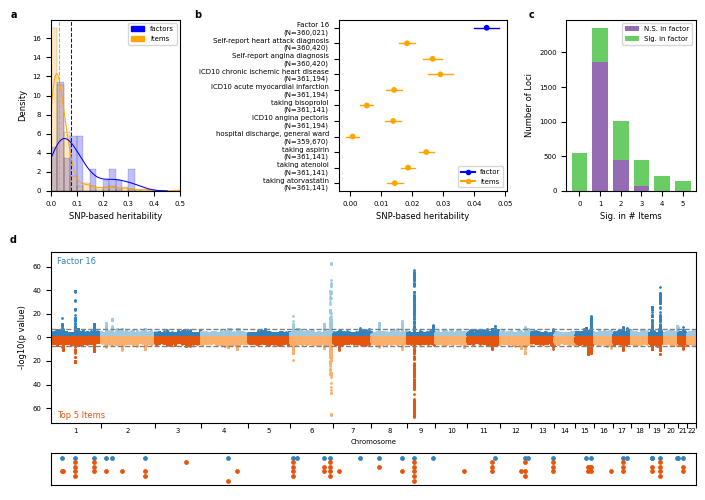

In [23]:
fig = plt.figure(figsize=(7.086, 5))
gs = fig.add_gridspec(nrows=4, ncols=4,height_ratios=[4, 0.01,4,0.75],width_ratios=[1,0.3,1.3,1],wspace=0.001,hspace=0)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(all_h2_rg.h2_full,stat="density",bins=np.arange(0,0.6,0.025),color="blue",alpha=0.25, fill=True,linewidth=0.1)
sns.histplot(nealeh2_items_only.h2_observed,stat="density",bins=np.arange(0,0.6,0.025),color="orange",alpha=0.25,fill=True,linewidth=0.1)
plt.axvline(x=np.median(all_h2_rg.h2_full),color="blue",label="factors",linewidth=0.75,linestyle='--')
plt.axvline(x=np.median(nealeh2_items_only.h2_observed),color="orange",label="items",linewidth=0.75,linestyle='--')
sns.kdeplot(nealeh2_items_only.h2_observed,color="orange",fill=False,linewidth=0.75)
#ax = plt.gca()
sns.kdeplot(all_h2_rg.h2_full,color="blue",fill=False,linewidth=0.75)

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='factors')
orange_patch = mpatches.Patch(color='orange', label='items')
ax1.legend(handles=[blue_patch, orange_patch], loc="upper right", fontsize=5)
ax1.set(xlim=(0, 0.5))
ax1.set_xlabel("SNP-based heritability", fontsize=6)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_ylabel("Density", fontsize=6)

ax2 = fig.add_subplot(gs[0, 2])
for factor in ["f16"]:
    cfafac = cfafactors.loc[cfafactors["factor"]==factor]
    cfafac["h2"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed"])
    cfafac["h2_se"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed_se"])
    cfafac["h2_lower"] = cfafac.h2-cfafac.h2_se
    cfafac["h2_upper"] = cfafac.h2+cfafac.h2_se
    
    toplot = cfafac[["item","h2","h2_lower","h2_upper"]]
    toplotfactor = pd.DataFrame(columns=["item ","h2","h2_lower","h2_upper"])
    toplotfactor = toplotfactor.append({"item" : "factor", "h2" : all_h2_rg.loc[factor,"h2"], "h2_lower" : all_h2_rg.loc[factor,"h2_lower"], "h2_upper" : all_h2_rg.loc[factor,"h2_upper"]},ignore_index=True)
    toplot = pd.concat([toplotfactor,toplot]).reset_index(drop=True).set_index("item")

    toplot["y"] = list(range(1,toplot.shape[0]+1))[::-1]
    toplot["color"] = "orange"
    toplot.loc["factor","color"]="blue"

    plt.scatter(x=toplot.h2,y=toplot.y,color=toplot.color, s=10)
    
    ylabels = ["taking atorvastatin\n(N=361,141)",
               "taking atenolol\n(N=361,141)",
               "taking aspirin\n(N=361,141)",
               "hospital discharge, general ward\n(N=359,670)",
               "ICD10 angina pectoris\n(N=361,194)",
               "taking bisoprolol\n(N=361,141)",
               "ICD10 acute myocardial infarction\n(N=361,194)",
               "ICD10 chronic ischemic heart disease\n(N=361,194)",
               "Self-report angina diagnosis\n(N=360,420)",
               "Self-report heart attack diagnosis\n(N=360,420)",
               "Factor 16\n(N=360,021)"]
    plt.yticks(range(1,len(toplot.h2)+1), ylabels)
    
    for item in toplot.index:
        lower = toplot.loc[item,"h2_lower"]
        upper = toplot.loc[item,"h2_upper"]
        yval = toplot.loc[item,"y"]
        plt.plot([lower,upper],[yval,yval],color=toplot.loc[item,"color"],linewidth=1)

    
    # plt.gca().yaxis.tick_right()
    ax2.set_xlabel("SNP-based heritability", fontsize=6)
    ax2.tick_params(axis='both', which='major', labelsize=5)
    factleg = mlines.Line2D([], [], color='blue', marker='o', markersize=3, label='factor')
    itemleg = mlines.Line2D([], [], color='orange', marker='o', markersize=3, label='items')
    leg = ax2.legend(handles=[factleg, itemleg], loc="lower right", fontsize=5)
    
    


ax3 = fig.add_subplot(gs[0, 3])

overall.plot(kind="bar",stacked="true",width=0.75,color=[sns.color_palette("muted")[4],sns.color_palette("muted")[2]],ax=ax3)
ax3.legend(["N.S. in factor", "Sig. in factor"], fontsize=5)
ax3.set_xlabel("Sig. in # Items", fontsize=6)
ax3.set_ylabel("Number of Loci", fontsize=6)
ax3.set_xticklabels(ax3.get_xticks(), rotation = 0)
ax3.tick_params(axis='both', which='major', labelsize=5)

ax4 = fig.add_subplot(gs[2, :])
x_labels = []
x_labels_pos = []
x_ticks_pos = []
for num, (name, group) in enumerate(data_grouped):        
    group.plot(kind='scatter', x='ind', y='-log10(p_value)', color=colorstop[num % len(colorstop)], ax=ax4, s=1,rasterized=True)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0]) / 2))
    x_ticks_pos.append(group['ind'].iloc[-1])
ax4.set_xticks(x_ticks_pos)
ax4.xaxis.set_minor_locator(plt.FixedLocator(x_labels_pos))
# ax4.set_xticklabels(x_labels, minor=True)
ax4.xaxis.set_minor_formatter(plt.FixedFormatter(x_labels))
ax4.xaxis.set_major_formatter(plt.NullFormatter())


ax4.set_xlim([0, len(data)])


dataitem_grouped = dataitem.groupby(("chr"))
for num, (name, group) in enumerate(dataitem_grouped):
        group.plot(kind='scatter', x='ind', y='-log10(p_value)', color=colorsbottom[num % len(colorsbottom)], ax=ax4, s=1,rasterized=True)
    
ax4.set_xlim([0, len(data)])
mymax = np.max([-1*dataitem['-log10(p_value)'].min(),data['-log10(p_value)'].max()])
ax4.set_ylim([-1*mymax-5, mymax+5])
# plt.title("Factor 16",fontsize=6)
ax4.set_ylabel("-log10(p value)", fontsize=6)
ax4.set_xlabel("Chromosome", fontsize=5)
    
plt.axhline(y=significance, color='gray', linestyle='--', linewidth = 1)
plt.axhline(y=-1*significance, color='gray', linestyle='--', linewidth = 1)
ax4.tick_params(axis='x', which='both', labelsize=5)
ax4.tick_params(axis='x', which='minor', width=0, length=0)
# plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
manh_yticks=[-60,-40,-20,0,20,40,60]
ax4.set_yticks(manh_yticks)
ax4.set_yticklabels([abs(x) for x in manh_yticks])

ax5 = fig.add_subplot(gs[3, :],sharex=ax4)

ys=6
for row in allloci.index:
    temp = allloci.loc[row]
    loci = temp[temp==1].index.tolist()
    xs = [data.loc[x.split("_")[1].rsplit(":",1)[0]].ind for x in loci]
    if row=="factor":
        plt.scatter(x=xs,y=[ys]*len(xs),color="#3182bd",marker="o",s=6)
    else:
        plt.scatter(x=xs,y=[ys]*len(xs),color="#e6550d",marker="o",s=6)
    ys = ys-1
ax5.set_ylim([0, 7])
# ax5.set_xlabel("Top 5 Items",fontsize=6)
# ax5.xaxis.set_label_coords(0.5,1.4)
ax5.tick_params(axis='both', which='major', labelsize=5)
ax5.axes.yaxis.set_visible(False)
ax5.axes.xaxis.set_visible(False)

fig.text(0.02,0.99, "a", 
      fontsize=7, fontweight='bold', va='top', ha='right')
fig.text(0.28,0.99, "b", 
      fontsize=7, fontweight='bold', va='top', ha='right')
fig.text(0.75,0.99, "c", 
      fontsize=7, fontweight='bold', va='top', ha='right')
fig.text(0.02,0.54, "d", 
      fontsize=7, fontweight='bold', va='top', ha='right')

ax4.text(0.01, 0.97, 'Factor 16', color="#3182bd", alpha=1, fontsize=6, horizontalalignment='left', verticalalignment='top', transform=ax4.transAxes)
ax4.text(0.01, 0.07, 'Top 5 Items', color="#e6550d", alpha=1, fontsize=6, horizontalalignment='left', verticalalignment='top', transform=ax4.transAxes)



gs.tight_layout(fig, h_pad=0, w_pad=-5.75)

plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/figures_RKWchecklist/Figure3_journal_RKW.pdf",format="pdf") # ,bbox_inches="tight"


#plt.show()

In [37]:
nealeh2_items.loc[nealeh2_items.phenotype.isin(toplot.index),]

,phenotype,sex,dilute,gwas_file,variable_type,n_missing,source,description,n,n_cases,...,isBadPower,isLowNeff,isMidNeff,isExtremeSE,isHighSE,isSexBias,isBadOrdinal,isNumericOrdinal,conf_simple,h2_sig
671,20003_1140866738,both_sexes,NaN,20003_1140866738.gwas.imputed_v3.both_sexes.ts...,binary,53,phesant,Treatment/medication code: atenolol,361141,13951.0,...,False,False,False,False,False,False,False,False,high,z7
687,20003_1140868226,both_sexes,NaN,20003_1140868226.gwas.imputed_v3.both_sexes.ts...,binary,53,phesant,Treatment/medication code: aspirin,361141,48081.0,...,False,False,False,False,False,False,False,False,high,z7
791,20003_1140879760,both_sexes,NaN,20003_1140879760.gwas.imputed_v3.both_sexes.ts...,binary,53,phesant,Treatment/medication code: bisoprolol,361141,5304.0,...,False,False,True,False,False,False,False,False,medium,nominal
949,20003_1141146234,both_sexes,NaN,20003_1141146234.gwas.imputed_v3.both_sexes.ts...,binary,53,phesant,Treatment/medication code: atorvastatin,361141,10805.0,...,False,False,False,False,False,False,False,False,high,z4
2789,41248_5001,both_sexes,NaN,41248_5001.gwas.imputed_v3.both_sexes.v2.tsv.bgz,binary,1524,phesant,Destinations on discharge from hospital (recod...,359670,5240.0,...,False,False,True,False,False,False,False,False,medium,nonsig
3150,6150_1,both_sexes,NaN,6150_1.gwas.imputed_v3.both_sexes.tsv.bgz,binary,774,phesant,Vascular/heart problems diagnosed by doctor: H...,360420,8288.0,...,False,False,True,False,False,True,False,False,medium,z7
3152,6150_2,both_sexes,NaN,6150_2.gwas.imputed_v3.both_sexes.tsv.bgz,binary,774,phesant,Vascular/heart problems diagnosed by doctor: A...,360420,11372.0,...,False,False,False,False,False,False,False,False,high,z7
3765,41202_I20,both_sexes,NaN,I20.gwas.imputed_v3.both_sexes.tsv.bgz,binary,0,icd10,Diagnoses - main ICD10: I20 Angina pectoris,361194,6246.0,...,False,False,True,False,False,False,False,False,medium,z4
3766,41202_I21,both_sexes,NaN,I21.gwas.imputed_v3.both_sexes.tsv.bgz,binary,0,icd10,Diagnoses - main ICD10: I21 Acute myocardial i...,361194,5948.0,...,False,False,True,False,False,True,False,False,medium,z4
3769,41202_I25,both_sexes,NaN,I25.gwas.imputed_v3.both_sexes.tsv.bgz,binary,0,icd10,Diagnoses - main ICD10: I25 Chronic ischaemic ...,361194,12769.0,...,False,False,False,False,False,True,False,False,medium,z7


In [55]:
overall

,factor_nosig,factor_sig
0,0,548
1,1864,486
2,446,566
3,67,373
4,1,218
5,0,138
